In [45]:
!pip install torch torchvision torchaudio
!pip install ipywidgets
!pip install openpyxl

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
folder_path = "C:/Users/harsh/Downloads/Data/Historical"

# Combine all CSVs
all_data = []
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_path, file))
        all_data.append(df)
data = pd.concat(all_data, ignore_index=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_26452\2118606305.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\harsh\AppData\Local\Temp\ipykernel_26452\2118606305.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\harsh\AppData\Local\Temp\ipykernel_26452\2118606305.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))
C:\Users\harsh\AppData\Local\Temp\ipykernel_26452\2118606305.py:7: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder_path, file))


In [33]:
# Manual input for route
origin = input("Enter ORIGIN airport code (e.g., DFW): ").strip().upper()
dest = input("Enter DESTINATION airport code (e.g., PHX): ").strip().upper()

# Filter for the selected route
df = data[(data["ORIGIN"] == origin) & (data["DEST"] == dest)].copy()

if df.empty:
    print(f"❌ No data found for route {origin} → {dest}")
else:
    print(f"✅ Loaded {len(df)} records for route {origin} → {dest}")

# Clean route-specific data
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.loc[~(df == 0).all(axis=1)]

drop_cols = [col for col in df.columns if df[col].dtype == 'object']
df = df.drop(columns=drop_cols)
# Sort the data by YEAR and MONTH
df = df.sort_values(by=["YEAR", "MONTH"]).reset_index(drop=True)

# 80/20 chronological split
split_index = int(0.8 * len(df))
train_df = df[:split_index]
test_df = df[split_index:]

# Separate features and target
target = "PASSENGERS"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

# Normalize using only training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


Enter ORIGIN airport code (e.g., DFW):  DFW
Enter DESTINATION airport code (e.g., PHX):  PHX


✅ Loaded 711 records for route DFW → PHX


In [35]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.model(x)

# Instantiate model
model = MLP(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_errors = []
num_epochs = 125
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    med_error = median_absolute_error(y_train_tensor.detach().numpy(), outputs.detach().numpy())
    train_errors.append(med_error)
    print(f"Epoch [{epoch+1}/{num_epochs}], Median Absolute Error: {med_error:.2f}")


Epoch [1/125], Median Absolute Error: 982.58
Epoch [2/125], Median Absolute Error: 982.51
Epoch [3/125], Median Absolute Error: 982.44
Epoch [4/125], Median Absolute Error: 982.38
Epoch [5/125], Median Absolute Error: 982.31
Epoch [6/125], Median Absolute Error: 982.22
Epoch [7/125], Median Absolute Error: 982.12
Epoch [8/125], Median Absolute Error: 982.01
Epoch [9/125], Median Absolute Error: 981.88
Epoch [10/125], Median Absolute Error: 981.72
Epoch [11/125], Median Absolute Error: 981.55
Epoch [12/125], Median Absolute Error: 981.36
Epoch [13/125], Median Absolute Error: 981.14
Epoch [14/125], Median Absolute Error: 980.94
Epoch [15/125], Median Absolute Error: 980.76
Epoch [16/125], Median Absolute Error: 980.55
Epoch [17/125], Median Absolute Error: 980.32
Epoch [18/125], Median Absolute Error: 980.06
Epoch [19/125], Median Absolute Error: 979.78
Epoch [20/125], Median Absolute Error: 979.46
Epoch [21/125], Median Absolute Error: 979.11
Epoch [22/125], Median Absolute Error: 978.

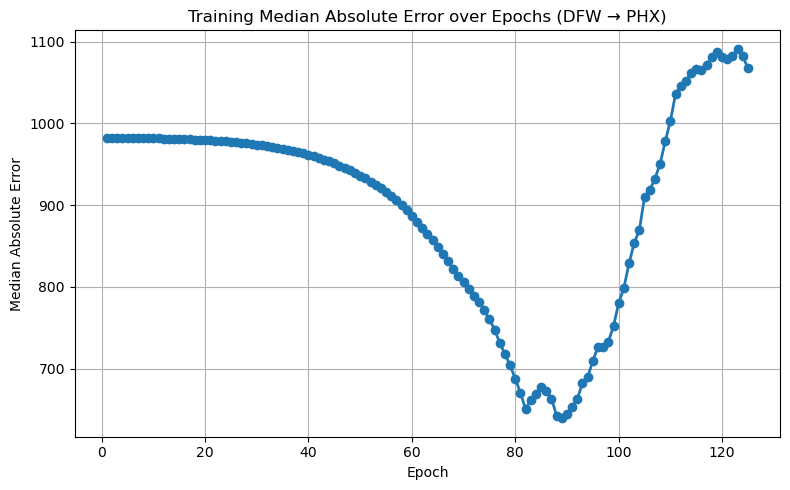

In [37]:
# Plot training error over epochs (for chronological split)
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_errors, marker='o', linewidth=2)
plt.title(f"Training Median Absolute Error over Epochs ({origin} → {dest})")
plt.xlabel("Epoch")
plt.ylabel("Median Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Results for route DFW → PHX:
🔢 R² Score: 0.8874
📊 Median Absolute Error: 1655.01
📈 Mean Absolute Percentage Error: 458.90%


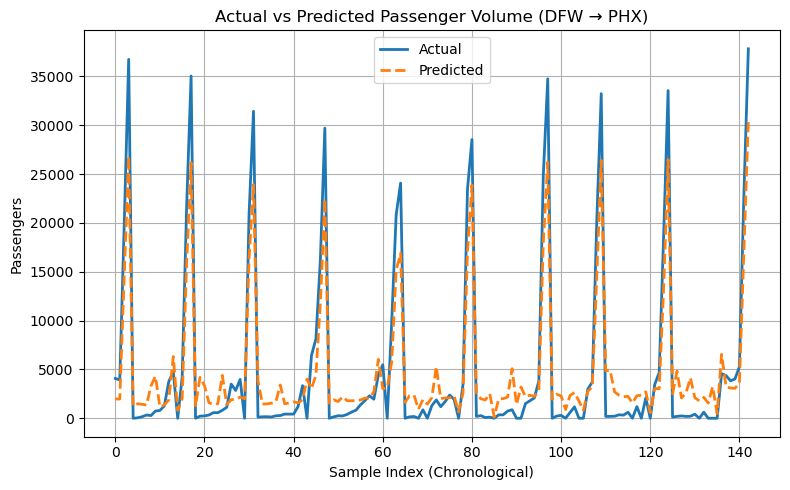

In [49]:
# Evaluate model on test set
# Evaluate model on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

    # Convert actual and predicted to numpy
    actual = y_test.values.flatten()
    predicted = y_pred.numpy().flatten()

    # Avoid division by zero in MAPE
    nonzero_mask = actual != 0
    actual_nonzero = actual[nonzero_mask]
    predicted_nonzero = predicted[nonzero_mask]

    r2 = r2_score(actual, predicted)
    med = median_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual_nonzero, predicted_nonzero) * 100

# Print evaluation metrics
print(f"\n✅ Results for route {origin} → {dest}:")
print(f"🔢 R² Score: {r2:.4f}")
print(f"📊 Median Absolute Error: {med:.2f}")
print(f"📈 Mean Absolute Percentage Error: {mape:.2f}%")

# Line plot: Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.plot(actual, label="Actual", linewidth=2)
plt.plot(predicted, label="Predicted", linewidth=2, linestyle='--')
plt.title(f"Actual vs Predicted Passenger Volume ({origin} → {dest})")
plt.xlabel("Sample Index (Chronological)")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Step 1: Inverse transform X_test
X_test_df = pd.DataFrame(scaler.inverse_transform(X_test_scaled), columns=X_test.columns)

# Step 2: Re-attach YEAR and MONTH from test_df
X_test_df["YEAR"] = test_df["YEAR"].values
X_test_df["MONTH"] = test_df["MONTH"].values

# Step 3: Create DATE column
X_test_df["DATE"] = pd.to_datetime(X_test_df[["YEAR", "MONTH"]].assign(DAY=1))

# Step 4: Predict using the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Step 5: Combine into one DataFrame
merged = pd.DataFrame({
    "DATE": X_test_df["DATE"],
    "YEAR": X_test_df["YEAR"],
    "MONTH": X_test_df["MONTH"],
    "ACTUAL_PASSENGERS": y_test.values,
    "PREDICTED_PASSENGERS": y_pred.numpy().flatten().round()
})

# Step 6: Save to CSV
merged.to_excel("predictions_with_actuals.xlsx", index=False)
print("✅ Merged dataset with actual and predicted values saved to 'predictions_with_actuals.xlsx'")

✅ Merged dataset with actual and predicted values saved to 'predictions_with_actuals.xlsx'
